In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
file_path = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
df = pd.read_csv(file_path)
# Chuyển đổi cột Date
if 'Date' in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print(f" Đã tải dữ liệu: {df.shape}")

print(df.head)

 Đã tải dữ liệu: (1693, 19)
<bound method NDFrame.head of            Date  Buffer pressure min  Buffer pressure max  \
0    2020-10-03                 32.2                 45.8   
1    2020-10-06                 15.1                 41.2   
2    2020-10-24                 47.7                 52.4   
3    2020-10-25                 48.6                 51.6   
4    2020-10-26                 50.2                 51.6   
...         ...                  ...                  ...   
1688 2025-08-13                 17.0                 20.7   
1689 2025-08-14                 17.0                 20.4   
1690 2025-08-15                 17.0                 20.6   
1691 2025-08-16                 16.8                 20.7   
1692 2025-08-17                 16.9                 20.2   

      Annulus pressure min  Annulus pressure max  Flow pressure min  \
0                     83.2                  83.9               15.0   
1                     77.9                  82.0               15.0

In [ ]:
# FEATURE ENGINEERING (TẠO BIẾN MỚI)
print("\n Đang xử lý dữ liệu...")
df['Water_cut_decimal'] = df['Water cut'] / 100

# Tránh lỗi chia cho 0
df['Qliq_target'] = df.apply(
    lambda row: row['Qoil'] / (1 - row['Water_cut_decimal']) if (1 - row['Water_cut_decimal']) > 0.01 else np.nan,
    axis=1
)

# Loại bỏ các dòng tính toán bị lỗi (NaN) hoặc vô cực
df_clean = df.dropna(subset=['Qliq_target']).copy()
print(f"   -> Số lượng mẫu sau khi lọc Qliq: {df_clean.shape[0]}")


 Đang xử lý dữ liệu...
   -> Số lượng mẫu sau khi lọc Qliq: 1693


In [ ]:
# Tạo các cột trung bình từ min-max
pair_features = {
   "Annulus pressure": ["Annulus pressure min", "Annulus pressure max"],
   "Buffer pressure": ["Buffer pressure min", "Buffer pressure max"],
   "T": ["T min", "T max"],
   "Flow pressure": ["Flow pressure min", "Flow pressure max"]
}

for new_col, cols in pair_features.items():
   col_min, col_max = cols
   if col_min in df_clean.columns and col_max in df_clean.columns:
       df_clean[f"{new_col}_avg"] = (df_clean[col_min] + df_clean[col_max]) / 2

# Danh sách đặc trưng đầu vào mới
features = [
   "Gas injection rate",
   "Annulus pressure_avg",
   "Buffer pressure_avg",
   "T_avg",
   "Flow pressure_avg",
   "Choke",
#   "Downtime"
]

# Chỉ giữ lại các cột có trong dữ liệu
features = [f for f in features if f in df_clean.columns]
X = df_clean[features]

#Imputation giá trị thiếu
X = X.fillna(method="ffill").fillna(method="bfill")
y = df_clean["Qliq_target"]

print(" Features đầu vào sau khi tạo AVG:")
print(features)

 Features đầu vào sau khi tạo AVG:
['Gas injection rate', 'Annulus pressure_avg', 'Buffer pressure_avg', 'T_avg', 'Flow pressure_avg', 'Choke']


/tmp/ipython-input-1398181077.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")


In [ ]:
# CHIA DỮ LIỆU (TIME-SERIES SPLIT)
# Chia theo thời gian: 80% quá khứ để train, 20% tương lai để test
split_point = int(len(df_clean) * 0.8)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Lưu lại Water Cut của tập Test để sau này tính ngược ra Qoil
wc_test = df_clean.iloc[split_point:]['Water_cut_decimal']

print(f" Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")

 Train size: 1354 | Test size: 339


In [ ]:
# làm mượt dữ liệu "y_train"
window_size_y = 2
y_train_original = y_train.copy() # tạo bản sao giá trị y_tran
y_train_smooth = y_train.rolling(window=window_size_y, min_periods=1).mean()
y_train = y_train_smooth

In [ ]:
# THIẾT LẬP TỰ ĐỘNG TÌM THAM SỐ (HYPERPARAMETER TUNING)

# Định nghĩa Pipeline cơ bản
base_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf_model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Định nghĩa không gian tìm kiếm tham số
param_dist = {
    'rf_model__n_estimators': [1000],       # Số lượng cây
    'rf_model__max_depth': [20],             # Độ sâu tối đa của cây
    'rf_model__min_samples_split': [2],                 # Số mẫu tối thiểu để chia nút
    'rf_model__min_samples_leaf': [10],               # Số mẫu tối thiểu tại lá
    'rf_model__max_features': ['log2'] ,          # Số lượng feature dùng để chia
}

# Thiết lập Cross-Validation cho chuỗi thời gian
# Chia tập train thành 3 phần kiểm thử gối đầu nhau để đảm bảo tính thời gian
tscv = TimeSeriesSplit(n_splits=3)

print("\n Đang chạy Randomized Search để tìm tham số tối ưu...")

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_dist,
    n_iter=50,                    # Thử ngẫu nhiên tổ hợp (tăng lên nếu máy mạnh)
    scoring='neg_mean_squared_error', # Tối ưu hóa dựa trên lỗi thấp nhất
    cv=tscv,                      # Sử dụng TimeSeriesSplit
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện tìm kiếm
random_search.fit(X_train, y_train)


 Đang chạy Randomized Search để tìm tham số tối ưu...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf_model',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rf_model__max_depth': [20],
                                        'rf_model__max_features': ['log2'],
                                        'rf_model__min_samples_leaf': [10],
                                        'rf_model__min_samples_split': [2],
                                        'rf_model__n_estimators': [1000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
best_model = random_search.best_estimator_
print("\n Đã tìm thấy tham số tốt nhất:")
print(random_search.best_params_)


 Đã tìm thấy tham số tốt nhất:
{'rf_model__n_estimators': 1000, 'rf_model__min_samples_split': 2, 'rf_model__min_samples_leaf': 10, 'rf_model__max_features': 'log2', 'rf_model__max_depth': 20}


In [ ]:
# DỰ BÁO & ĐÁNH GIÁ
y_pred_liq = best_model.predict(X_test)

# Đánh giá Q_Liquid
r2_liq = r2_score(y_test, y_pred_liq)
rmse_liq = np.sqrt(mean_squared_error(y_test, y_pred_liq))
mae_liq = np.sqrt(mean_absolute_error(y_test, y_pred_liq))
mape_liq = np.sqrt(mean_absolute_percentage_error(y_test, y_pred_liq))

print("\n KẾT QUẢ DỰ BÁO Q_LIQUID:")
print(f"   R² Score: {r2_liq:.4f}")
print(f"   RMSE:     {rmse_liq:.4f}")
print(f"   MAE:     {mae_liq:.4f}")
print(f"   MAPE:     {mape_liq:.4f}")


# Tính ngược ra Q_Oil
y_pred_oil = y_pred_liq * (1 - wc_test)
y_true_oil = df_clean.iloc[split_point:]['Qoil']

r2_oil = r2_score(y_true_oil, y_pred_oil)
rmse_oil = np.sqrt(mean_squared_error(y_true_oil, y_pred_oil))
mae_oil = np.sqrt(mean_absolute_error(y_true_oil, y_pred_oil))
mape_oil = np.sqrt(mean_absolute_percentage_error(y_true_oil, y_pred_oil))


print("\n KẾT QUẢ DỰ BÁO Q_OIL (SAU KHI QUY ĐỔI):")
print(f"   R² Score: {r2_oil:.4f}")
print(f"   RMSE:     {rmse_oil:.4f} m3/ngày")
print(f"   MAE:     {mae_oil:.4f} m3/ngày")
print(f"   MAPE:     {mape_oil:.4f} ")


 KẾT QUẢ DỰ BÁO Q_LIQUID:
   R² Score: 0.5284
   RMSE:     9.3103
   MAE:     2.4985
   MAPE:     0.1935

 KẾT QUẢ DỰ BÁO Q_OIL (SAU KHI QUY ĐỔI):
   R² Score: 0.8415
   RMSE:     2.4831 m3/ngày
   MAE:     1.3176 m3/ngày
   MAPE:     0.1935 


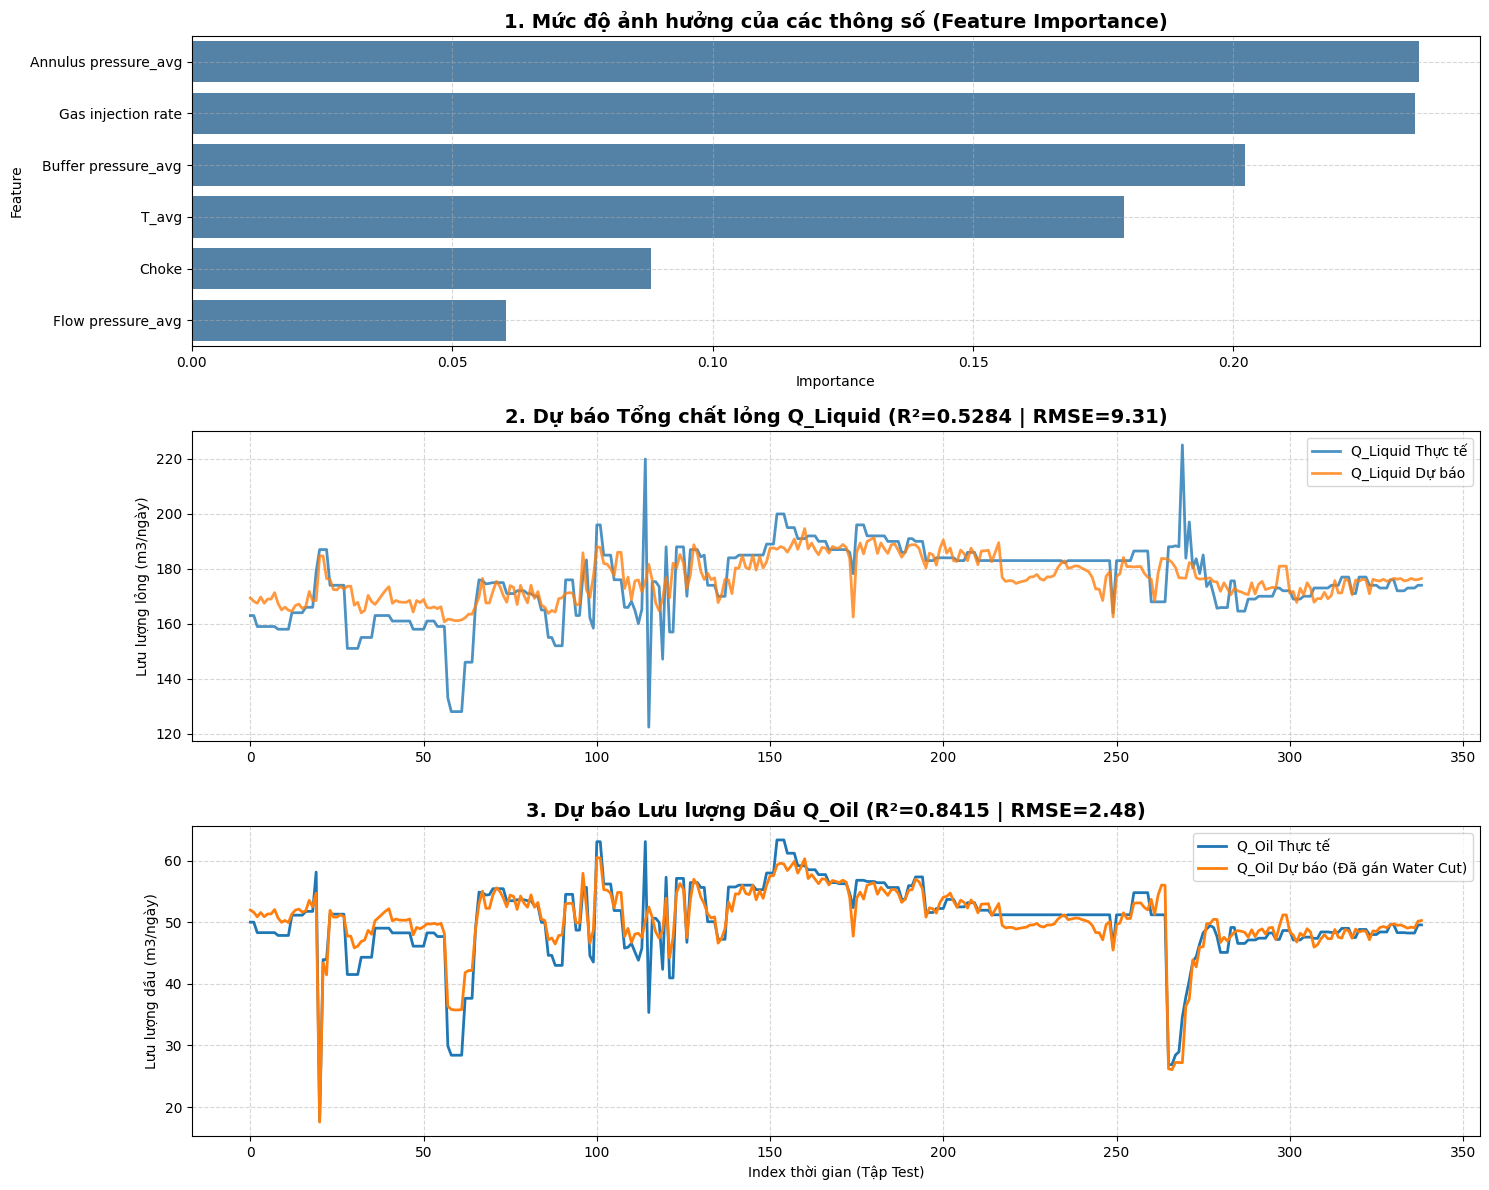

In [ ]:
# TRỰC QUAN HÓA

plt.figure(figsize=(15, 12))

# --- Biểu đồ 1: Feature Importance ---
plt.subplot(3, 1, 1)
if hasattr(best_model, 'named_steps'): # Kiểm tra nếu dùng Pipeline
    importances = best_model.named_steps["rf_model"].feature_importances_
else:
    importances = best_model.feature_importances_

feat_imp = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=feat_imp, color="steelblue")
plt.title("1. Mức độ ảnh hưởng của các thông số (Feature Importance)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.5)

# --- Biểu đồ 2: So sánh Q_LIQUID (Output trực tiếp của mô hình) ---
plt.subplot(3, 1, 2)
plt.plot(y_test.values, label="Q_Liquid Thực tế", color='tab:blue', linewidth=2, alpha=0.8)
plt.plot(y_pred_liq, label="Q_Liquid Dự báo", color='tab:orange', linewidth=2, alpha=0.8)
plt.title(f"2. Dự báo Tổng chất lỏng Q_Liquid (R²={r2_liq:.4f} | RMSE={rmse_liq:.2f})", fontsize=14, fontweight='bold')
plt.ylabel("Lưu lượng lỏng (m3/ngày)")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.5)

# So sánh Q_Oil
plt.subplot(3, 1, 3)
plt.plot(y_true_oil.values, label="Q_Oil Thực tế", color='tab:blue', linewidth=2)
plt.plot(y_pred_oil.values, label="Q_Oil Dự báo (Đã gán Water Cut)", color='tab:orange', linewidth=2)
plt.title(f"3. Dự báo Lưu lượng Dầu Q_Oil (R²={r2_oil:.4f} | RMSE={rmse_oil:.2f})", fontsize=14, fontweight='bold')
plt.xlabel("Index thời gian (Tập Test)")
plt.ylabel("Lưu lượng dầu (m3/ngày)")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

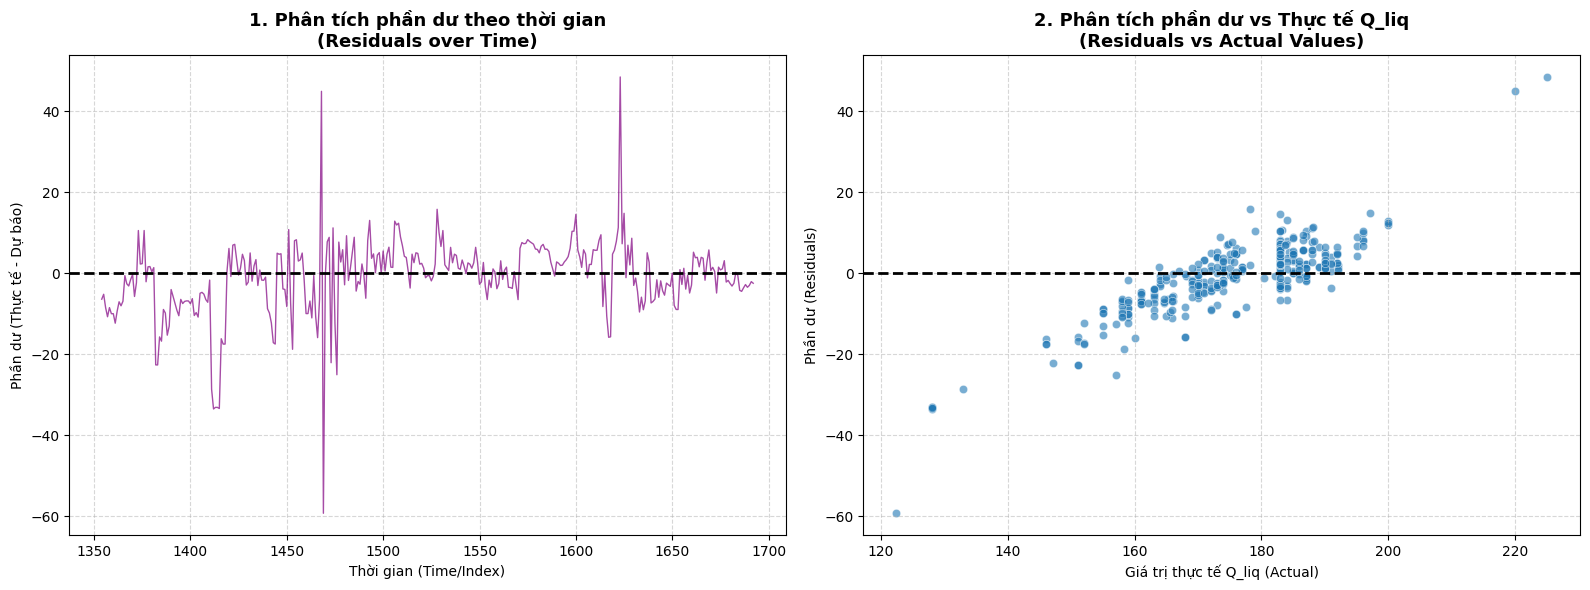

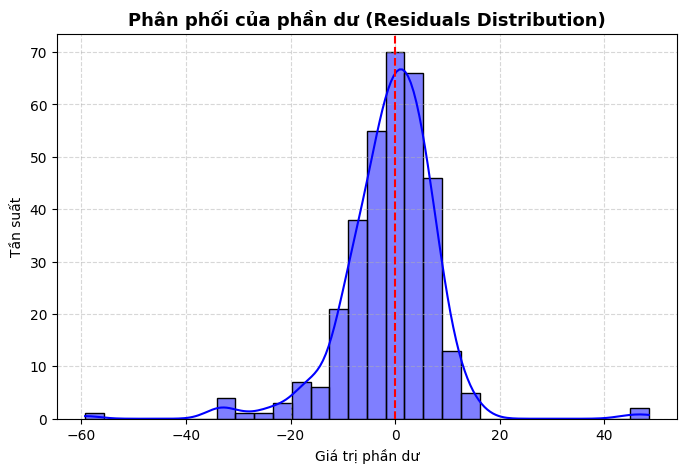

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# TÍNH TOÁN PHẦN DƯ (RESIDUALS)
# Residuals = Thực tế - Dự báo
residuals = y_test - y_pred_liq

# Tạo DataFrame tạm thời để thuận tiện cho việc vẽ (giữ lại index thời gian nếu có)
df_residuals = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_liq,
    'Residuals': residuals
})

# VẼ BIỂU ĐỒ
plt.figure(figsize=(16, 6))

# Biểu đồ Phần dư theo Thời gian (Residuals over Time)
plt.subplot(1, 2, 1)
plt.plot(df_residuals.index, df_residuals['Residuals'], color='purple', linewidth=1, alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=2)  # Đường 0 tham chiếu
plt.title('1. Phân tích phần dư theo thời gian\n(Residuals over Time)', fontsize=13, fontweight='bold')
plt.xlabel('Thời gian (Time/Index)')
plt.ylabel('Phần dư (Thực tế - Dự báo)')
plt.grid(True, linestyle='--', alpha=0.5)

# Biểu đồ Phần dư vs Thực tế Q_liq (Residuals vs Actual)
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_residuals['Actual'], y=df_residuals['Residuals'], alpha=0.6, edgecolor='w')
plt.axhline(0, color='black', linestyle='--', linewidth=2) # Đường 0 tham chiếu
plt.title('2. Phân tích phần dư vs Thực tế Q_liq\n(Residuals vs Actual Values)', fontsize=13, fontweight='bold')
plt.xlabel('Giá trị thực tế Q_liq (Actual)')
plt.ylabel('Phần dư (Residuals)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# KIỂM TRA PHÂN PHỐI PHẦN DƯ
# Nếu phân phối có dạng hình chuông (chuẩn) quanh số 0 là tốt
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Phân phối của phần dư (Residuals Distribution)', fontsize=13, fontweight='bold')
plt.xlabel('Giá trị phần dư')
plt.ylabel('Tần suất')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [157]:
import joblib

model_filename = 'RandomForest.pkl'
save_path = f'/content/drive/MyDrive/Model ML/{model_filename}'

# Kiểm tra xem folder có tồn tại không, nếu không thì lưu ở thư mục hiện tại
try:
    joblib.dump(best_model, save_path)
    print(f"✅ Đã lưu mô hình thành công tại: {save_path}")
except FileNotFoundError:
    # Trường hợp không tìm thấy đường dẫn Drive, lưu tạm ở bộ nhớ Colab
    joblib.dump(best_model, model_filename)
    print(f"⚠️ Không tìm thấy đường dẫn Drive. Đã lưu tạm tại: {os.path.abspath(model_filename)}")

✅ Đã lưu mô hình thành công tại: /content/drive/MyDrive/Model ML/RandomForest.pkl
